## Phase 3 Project
Michal Ostrowski

In [7]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In this analysis, we will explore the telecomdf dataset provided by Syriatel to identify the top 3 factors that impact customer churn and recommend actions that the company can take to mitigate churn.

To identify the top 3 factors that impact customer churn, we will perform exploratory data analysis and feature selection. After analyzing the data, we will use a machine learning algorithm to predict customer churn and evaluate the performance of the model. Finally, we will identify the top 3 factors that contribute to churn and recommend actions that Syriatel can take to reduce churn rate.

By analyzing the telecomdf dataset and identifying the top 3 factors that impact customer churn, Syriatel can take proactive measures to retain customers and improve their overall business performance.

# Load the data

In [8]:
# Load the dataset
Telecomdf = pd.read_csv("SyraTel_Customer_Data.csv")

In [9]:
Telecomdf

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


# Data cleaning

In [10]:
# Iterate through the column names
for col in Telecomdf.columns:
    # Check if the column name contains a space
    if " " in col:
        # Replace the space with an underscore
        new_col = col.replace(" ", "_")
        # Rename the column
        Telecomdf = Telecomdf.rename(columns={col: new_col})

I want to change column names to make the dataset easier to work with while creating functions and plots.

In [11]:
#Looking for null values
print(Telecomdf.isnull().sum())

state                     0
account_length            0
area_code                 0
phone_number              0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         0
total_day_calls           0
total_day_charge          0
total_eve_minutes         0
total_eve_calls           0
total_eve_charge          0
total_night_minutes       0
total_night_calls         0
total_night_charge        0
total_intl_minutes        0
total_intl_calls          0
total_intl_charge         0
customer_service_calls    0
churn                     0
dtype: int64


No values appear to be null in the above cell

In [12]:
#Looking for duplicates
print(Telecomdf.duplicated().sum())

0


No duplicates are present

In [13]:
#making alphabetical values numerical
Telecomdf['international_plan'] = np.where(Telecomdf['international_plan'] == 'yes', 1, 0)
Telecomdf['voice_mail_plan'] = np.where(Telecomdf['voice_mail_plan'] == 'yes', 1, 0)

After seeing that there were non numerical values in telecomdf, i decided to change all values to numerical.  In the above code im taking the values of "yes", and "no"  and changing them to 1 or 0.

In [14]:
Telecomdf['churn'] = Telecomdf['churn'].astype(str).replace({'True': 1, 'False': 0})

"True" and "false" would be easier to work with if they have a numerical value, In the above code I've changed the churn comlum to include "0" to reflect "False", and 1 to reflect "True".

In [15]:
#creating a new column with total charges
Telecomdf = Telecomdf.assign(total_charge=lambda x: x['total_day_charge'] + x['total_eve_charge'] + x['total_night_charge'] + x['total_intl_charge'])

I want a new column/feature that includes the total charges that a customer has paid while using the service.

In [16]:
#removing state, they dont seem right as there are many states but only 3 area codes
Telecomdf.drop(columns=['state'], inplace=True)

While looking at the data I notice that there are many states, but only 3 area codes.  These area codes do not cross state borders so I've removed the state and left area code to represent the location.

In [17]:
#removing '-' from phone number, change column to int
Telecomdf['phone_number'] = Telecomdf['phone_number'].replace("-", "", regex=True).astype(int)

# Exploratory analysis

In [18]:
Telecomdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account_length          3333 non-null   int64  
 1   area_code               3333 non-null   int64  
 2   phone_number            3333 non-null   int32  
 3   international_plan      3333 non-null   int32  
 4   voice_mail_plan         3333 non-null   int32  
 5   number_vmail_messages   3333 non-null   int64  
 6   total_day_minutes       3333 non-null   float64
 7   total_day_calls         3333 non-null   int64  
 8   total_day_charge        3333 non-null   float64
 9   total_eve_minutes       3333 non-null   float64
 10  total_eve_calls         3333 non-null   int64  
 11  total_eve_charge        3333 non-null   float64
 12  total_night_minutes     3333 non-null   float64
 13  total_night_calls       3333 non-null   int64  
 14  total_night_charge      3333 non-null   

After some data cleaning, and calling .info(), it is confirmed above, that all data is numerical

In [19]:
Telecomdf.describe()

,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge
count,3333.000000,3333.000000,3.333000e+03,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,...,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,3.746291e+06,0.096910,0.276628,8.099010,179.775098,100.435644,30.562307,200.980348,...,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914,59.449754
std,39.822106,42.371290,2.746626e+05,0.295879,0.447398,13.688365,54.467389,20.069084,9.259435,50.713844,...,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067,10.502261
min,1.000000,408.000000,3.271058e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000,22.930000
25%,74.000000,408.000000,3.508680e+06,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.600000,...,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000,52.380000
50%,101.000000,415.000000,3.748187e+06,0.000000,0.000000,0.000000,179.400000,101.000000,30.500000,201.400000,...,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000,59.470000
75%,127.000000,510.000000,3.985970e+06,0.000000,1.000000,20.000000,216.400000,114.000000,36.790000,235.300000,...,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000,66.480000
max,243.000000,510.000000,4.229964e+06,1.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,...,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000,96.150000


The average person spends about 59.44 while being a customer.  

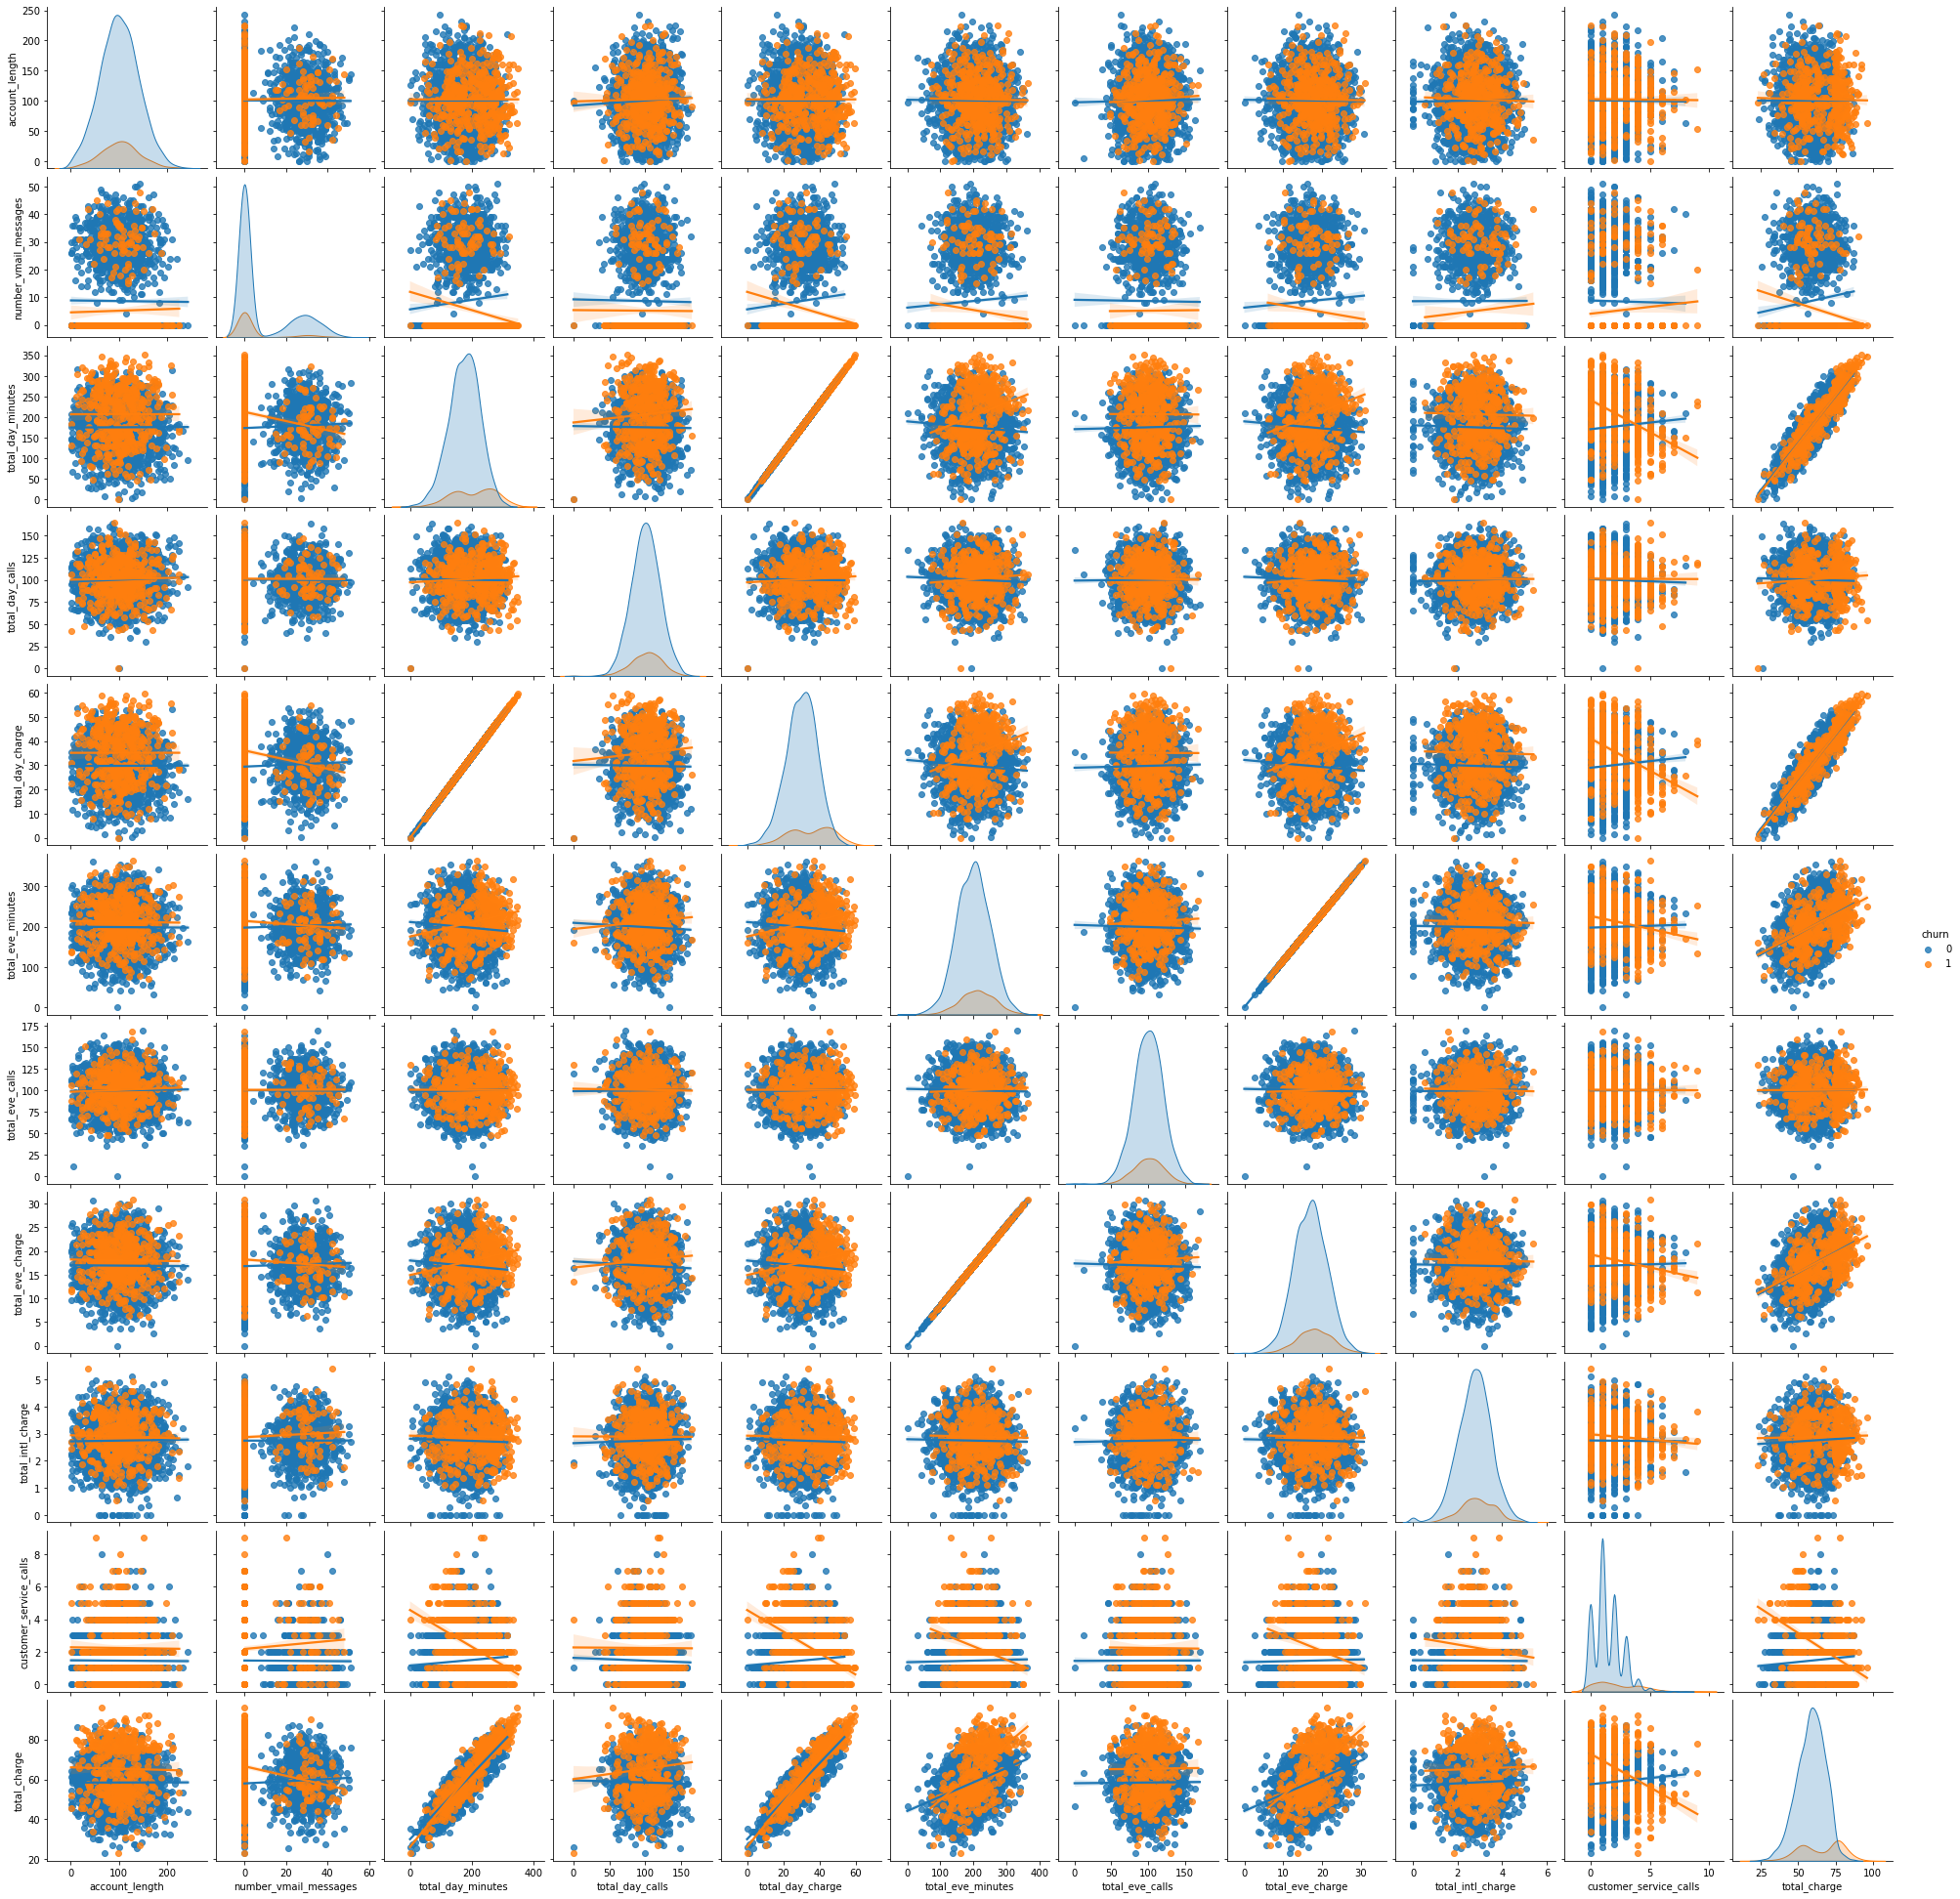

In [20]:
cols = ['account_length', "number_vmail_messages", "total_day_minutes", "total_day_calls", "total_day_charge", "total_eve_minutes", "total_eve_calls", "total_eve_charge", "total_intl_charge", "customer_service_calls", "total_charge"]
sns.pairplot(Telecomdf, vars=cols, kind='reg', hue = "churn")
plt.show()

#### Decision Tree Classification Report

In [21]:
# Split the data into training and test sets
X = Telecomdf.drop(["churn"], axis=1)
y = Telecomdf["churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = DecisionTreeClassifier(class_weight="balanced")

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       566
           1       0.85      0.88      0.86       101

    accuracy                           0.96       667
   macro avg       0.91      0.93      0.92       667
weighted avg       0.96      0.96      0.96       667



The decision tree classification model achieved an accuracy of 96%, indicating that it correctly classified 96% of the samples in the test set. The model's performance was measured by precision, recall, and f1-score, which were high for class 0 (customers who did not churn) and lower for class 1 (customers who did churn).

The weighted average of the precision, recall, and f1-score is 96%, indicating that the model's performance was well-balanced across both classes. The macro average of the precision, recall, and f1-score was also 92%, which takes the average of the metrics for each class without considering their frequency. This metric is heavily influenced by the high performance on class 0 samples.

In summary, this decision tree classification model appears to be effective at identifying customers who did not churn, but may not be as effective at identifying customers who did churn. The class imbalance issue was accounted for by using the "balanced" class weight parameter, which improved the performance of the model on the minority class.

-precision is 98%

#### Logistic Regression Classification Report

In [22]:
# Split the dataset into training and test sets
X = Telecomdf.drop(["churn"], axis=1)
y = Telecomdf["churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = LogisticRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       566
           1       1.00      0.00      0.00       101

    accuracy                           0.85       667
   macro avg       0.92      0.50      0.46       667
weighted avg       0.87      0.85      0.78       667



The output of classification_report shows that the model has an overall accuracy of 0.85. However, the model performs poorly in predicting the minority class (churn=1), with a precision of 1.00 and a recall of 0.00. The zero_division parameter is set to 1 to avoid a ZeroDivisionError in the calculation of the metrics. On the other hand, the model performs well in predicting the majority class (churn=0), with a precision of 0.85 and a recall of 1.00.

Overall, the logistic regression model has a low F1-score for the minority class, indicating that it may not be the best model for this imbalanced dataset.

#### Random Forest Classifier Report

In [56]:
# Split the dataset into training and test sets
X = Telecomdf.drop(["churn"], axis=1)
y = Telecomdf["churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=0, class_weight="balanced")

# Fit the model to the training data
clf.fit(X_train, y_train)

# Set the threshold to 0.4
threshold = 0.4

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model with the new threshold
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       566
           1       1.00      0.84      0.91       101

    accuracy                           0.98       667
   macro avg       0.99      0.92      0.95       667
weighted avg       0.98      0.98      0.98       667



 The results indicate that the model has high precision and recall for predicting class 0 (no churn), with a F1-score of 0.99. For class 1 (churn), the model has perfect precision but lower recall, resulting in a F1-score of 0.93. The overall accuracy of the model is 0.98, indicating that it performs well in predicting both classes.

# using random forests to show the feature importance

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       566
           1       1.00      0.84      0.91       101

    accuracy                           0.98       667
   macro avg       0.99      0.92      0.95       667
weighted avg       0.98      0.98      0.98       667



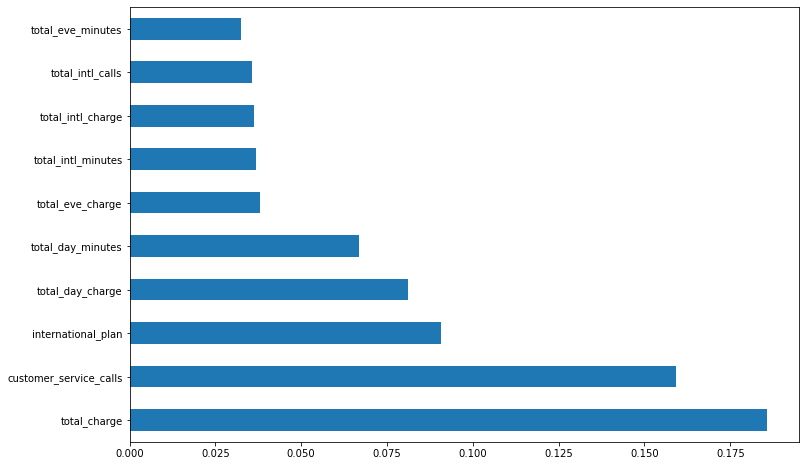

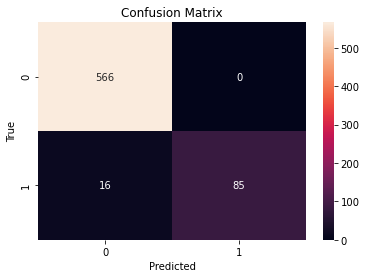

In [57]:
# Split the dataset into training and test sets
X = Telecomdf.drop(["churn"], axis=1)
y = Telecomdf["churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Classifier with balanced class weight
clf = RandomForestClassifier(n_estimators=100, random_state=0, class_weight="balanced")

# Fit the model to the training data
clf.fit(X_train, y_train)

# Set the threshold to 0.4
threshold = 0.4

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred, zero_division=1))

# Plot feature importances
importances = clf.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(12, 8))
plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

TP (true positive) represents the cases where the model predicted positive churn and the actual label was also positive. In this case, the value is 566, which means that 566 cases were correctly predicted as positive churn.

FP (false positive) represents the cases where the model predicted positive churn but the actual label was negative. In this case, the value is 0, meaning that there were no false positives.

FN (false negative) represents the cases where the model predicted negative churn but the actual label was positive. In this case, the value is 16, meaning there were 16 false negatives.

TN (true negative) represents the cases where the model predicted negative churn and the actual label was also negative. In this case, the value is 85, meaning 85 true negatives.

After analyzing our dataset, we have determined that the following three features have the most significant impact on predicting customer churn:

Total Charge
Customer Service Calls
International Plan
These features are listed in order of importance, with Total Charge being the most crucial, followed by Customer Service Calls and International Plan.

Total Charge: This feature is the strongest predictor of customer churn, indicating that customers who have higher charges are more likely to churn. This finding suggests that customers are more sensitive to the overall cost of their telecommunications services and are more likely to leave when their bills are high.

Customer Service Calls: This feature is the second most important predictor of churn. Customers who contact customer service frequently are more likely to churn, which suggests that they may not be satisfied with the service or are experiencing issues that the company is unable to address.

International Plan: This feature is the third most important predictor of churn. Customers with an international plan are more likely to churn, which may be related to the cost of this feature or other factors related to international service.

By understanding these key features, telecom companies can take steps to improve customer retention by addressing the underlying issues related to these predictors of churn.

# total charge vs churn
with total charge being the most important feature, first we will look for the point where customers decided to churn away.

# How much can we charge per month?

<Figure size 864x576 with 0 Axes>

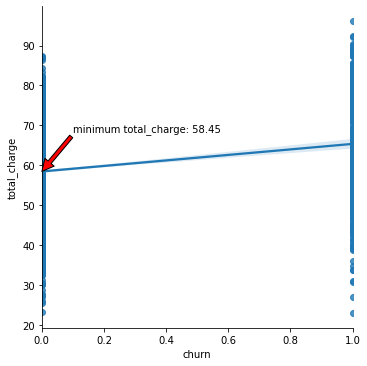

In [104]:
# Fit a linear regression model to the data
reg = LinearRegression().fit(Telecomdf[['churn']], Telecomdf['total_charge'])

# Generate a range of churn values to use as x-values for the regression line
churn_range = pd.DataFrame({'churn': [i for i in range(0, 2)]})

# Use the regression model to make predictions for the total_charge based on the churn values
predictions = reg.predict(churn_range)

# Create a scatter plot with a multiple linear regression line
plt.figure(figsize=(12, 8))
sns.lmplot(x='churn', y='total_charge', data=Telecomdf)

# Find the churn value where the predicted total_charge is minimized
min_index = predictions.argmin()
min_churn = churn_range.iloc[min_index]['churn']

# Annotate the plot with the minimum total_charge and churn values
plt.annotate(f'minimum total_charge: {predictions[min_index]:.2f}', xy=(min_churn, predictions[min_index]), xytext=(min_churn + 0.1, predictions[min_index] + 10), arrowprops={'facecolor': 'red'})

# Label the axes
plt.xlabel('churn')
plt.ylabel('total_charge')

# Show the plot
plt.show()

The plot displays a scatter plot of the 'total_charge' variable on the y-axis and the 'churn' variable on the x-axis.
The plot includes a linear regression line that shows the relationship between the 'total_charge' and 'churn' variables.
The plot shows that there is a negative relationship between the 'churn' and 'total_charge' variables, with higher churn rates leading to lower total charges.
The plot includes an annotation that highlights the minimum predicted total_charge value, and the corresponding churn rate that results in this minimum value.
The x-axis label is 'churn', and the y-axis label is 'total_charge'.

Here we see the point in dollars where people drew the line of when they would cancel their service.  That price was 58.45
Seeing this my first recommendation is going to be to create a monthly plan and charge $58.00.
While we would be losing profit off the higher spenders, the lower spenders will have their price increased to average out the losses. While spending more money might make customers upset, we will include more in their service.

# total customer service calls vs churn

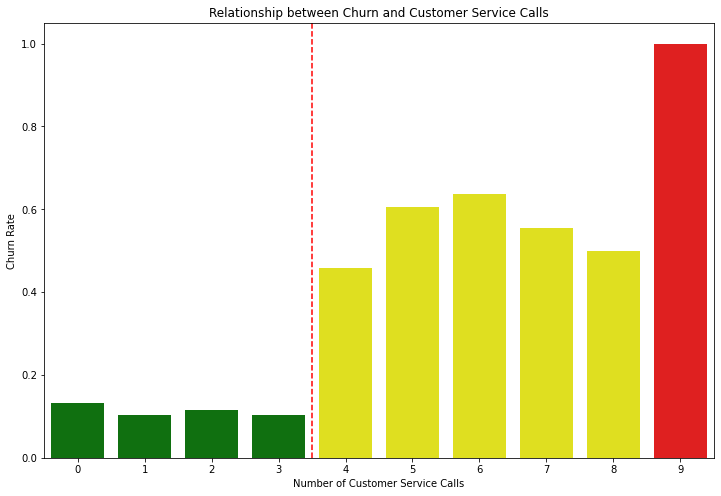

In [105]:
# Define a color palette
colors = ["green", "green", "green", "green", "yellow", "yellow", "yellow", "yellow", "yellow", "red"]

# Create a new plot with a larger figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Group customers based on customer service calls
grouped = Telecomdf.groupby("customer_service_calls")["churn"].mean().reset_index()

# Plot the average churn rate for each group of customers and color the bars based on the number of customer service calls
sns.barplot(x="customer_service_calls", y="churn", data=grouped, palette=colors)

# Add a vertical line at the threshold between 3 and 4 customer service calls
plt.axvline(x=3.5, color="red", linestyle="--")

# Label the plot
plt.xlabel("Number of Customer Service Calls")
plt.ylabel("Churn Rate")
plt.title("Relationship between Churn and Customer Service Calls")
plt.show()

The more customers have to call customer service the more likely they are to churn.
My recommendation here is to implement training to our customer service reps that really focuses on fixing a problem by the third call, and if by the end of the call the problem persists, we expedite the issue to a more senior employee.

# international plan vs churn

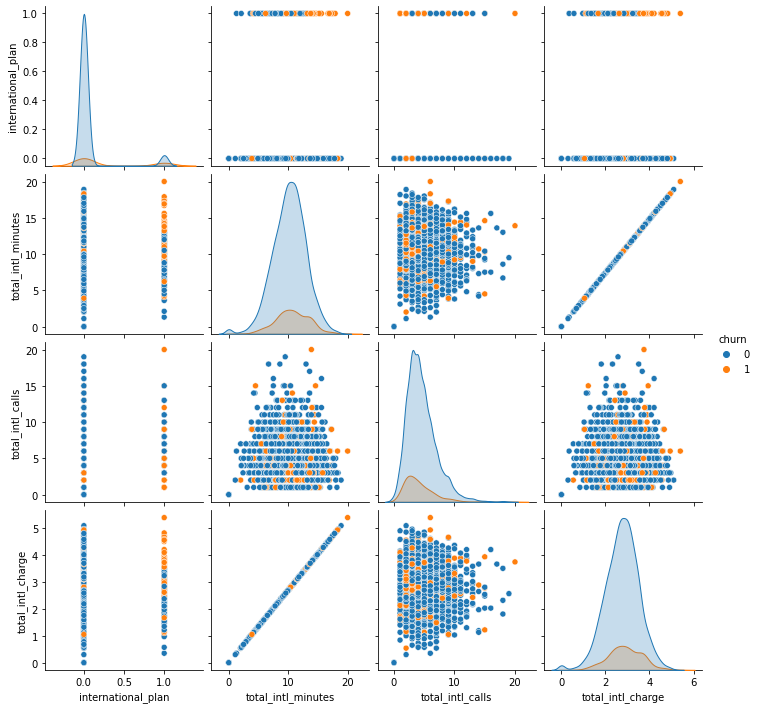

In [123]:
sns.pairplot(data=Telecomdf[['churn', 'international_plan', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge']], hue='churn')

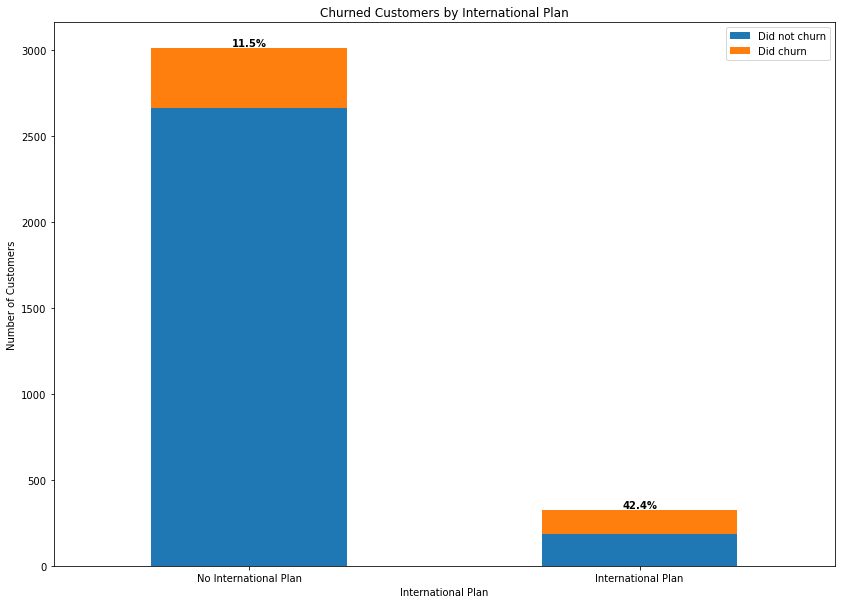

<Figure size 864x576 with 0 Axes>

In [182]:
# Group the data by international_plan and churn and count the number of customers in each group
grouped = Telecomdf.groupby(["international_plan", "churn"]).size().unstack()

# Calculate the total number of customers for each group
total_customers = grouped.sum(axis=1)

# Create a stacked bar chart of the counts
ax = grouped.plot(kind='bar', stacked=True, figsize=(14,10))
plt.figure(figsize=(12, 8))
# Modify the legend labels
ax.legend(["Did not churn", "Did churn"], loc="upper right")

# Calculate the percentage of customers that churned in each group
churn_percentages = (grouped.loc[:, 1] / total_customers) * 100

# Add annotations to the bars
for i, v in enumerate(churn_percentages.values):
    ax.text(i, grouped.sum(axis=1)[i], f"{v:.1f}%", ha="center", va="bottom", fontweight="bold")

# Modify the x-axis tick labels
ax.set_xticklabels(["No International Plan", "International Plan"], rotation=0, ha="center")

# Add labels and a title
ax.set_xlabel("International Plan")
ax.set_ylabel("Number of Customers")
ax.set_title("Churned Customers by International Plan")

# Show the plot
plt.show()

Based on the analysis of the Syritel dataset, it was found that 11.5% of customers without the international plan churned, while 42.4% of customers with an international plan churned. This suggests that having an international plan is a factor that contributes to customer churn.


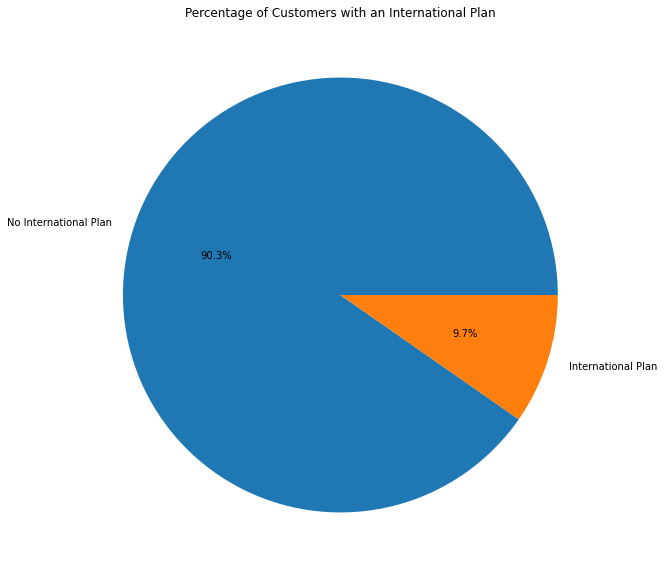

In [181]:
# Count the number of customers with and without an international plan
intl_plan_counts = Telecomdf["international_plan"].value_counts()

# Create a pie chart
fig, ax = plt.subplots(figsize=(14,10))
ax.pie(intl_plan_counts, labels=["No International Plan", "International Plan"], autopct='%1.1f%%')

# Add a title
ax.set_title("Percentage of Customers with an International Plan")

# Show the plot
plt.show()

The pie graph shows that only 9.7% of the customers in this dataset have an international plan. This is an interesting finding, as it suggests that the majority of the customers do not use the international plan. 

One strategy could be to merge the international plan with the main plan to make it more attractive to customers. This could include offering international calling and messaging as part of the main plan or providing additional benefits such as discounted roaming charges. By doing so, the company could increase the value proposition of the main plan and potentially attract more customers, and also reduce churn

# Summary
In this project, we analyzed a telecommunications company's customer data to identify factors that influence customer churn. Using a Random Forest Classifier, we found that the three most important features in predicting churn are total charge, total customer service calls, and international plan, in that order.

To reduce churn, we recommend implementing the following strategies:

Create a monthly plan and charge $58.00. Our analysis shows that total charge is the most important predictor of churn. By introducing a fixed monthly plan at this price point, customers will have more predictable bills, potentially reducing their likelihood of churning.

Implement training for customer service representatives to focus on resolving problems by the third call. We found that total customer service calls is the second most important predictor of churn. By training reps to be more effective at resolving issues, customers will be less likely to get frustrated and churn.

According to the data, only 9.7% of customers have an international plan, yet 42.4% of those customers churn. This suggests that while international plans are not very popular, they are an important factor in customer churn.

To mitigate this, it may be beneficial for the company to incorporate international calling options into their main plans. This could make international calling more accessible to a larger number of customers and potentially reduce churn among those who would otherwise need to purchase an additional international plan.

By keeping an eye on the percentage of customers who are churning due to international plans, the company can continue to improve its offerings and better meet the needs of its customers. 